In [1]:
import argparse
import os
import pathlib
import pprint
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from PIL import Image
from ultrack import to_tracks_layer, track, tracks_to_zarr
from ultrack.config import MainConfig
from ultrack.tracks import close_tracks_gaps
from ultrack.utils import estimate_parameters_from_labels, labels_to_contours

# check if in a jupyter notebook

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(f"Running in notebook: {in_notebook}")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# check gpu
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if not gpu_devices:
    print("No GPU found")
else:
    print("GPU found")


# tensorflow clear gpu memory
def clear_gpu_memory():
    from numba import cuda

    cuda.select_device(0)
    cuda.close()


clear_gpu_memory()
import napari
from napari.utils.notebook_display import nbscreenshot

Running in notebook: True


2025-08-22 08:59:23.643292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755874763.662917  408973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755874763.669538  408973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-22 08:59:23.733337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU found


In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    well_fov = args.well_fov

else:
    print("Running in a notebook")
    well_fov = "C-02_F0003"  # example well_fov


input_dir = pathlib.Path(
    f"../../2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_{well_fov}"
).resolve(strict=True)
terminal_mask_file_dir = pathlib.Path(
    f"../../2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{well_fov}/{well_fov}_T0014_Z0001_nuclei_mask_aligned.tiff"
).resolve(strict=True)
terminal_nuclei_file_dir = pathlib.Path(
    f"../../2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{well_fov}/{well_fov}_T0014_Z0001_C01_illumcorrect_aligned.tiff"
).resolve(strict=True)

temporary_output_dir = pathlib.Path("../tmp_output").resolve()
figures_output_dir = pathlib.Path("../figures").resolve()
results_output_dir = pathlib.Path("../results").resolve()
temporary_output_dir.mkdir(exist_ok=True)
figures_output_dir.mkdir(exist_ok=True)
results_output_dir.mkdir(exist_ok=True)

Running in a notebook


FileNotFoundError: [Errno 2] No such file or directory: '../../2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-02_F0003/C-02_F0003_T0014_Z0001_nuclei_mask_aligned.tiff'

In [ ]:
print(f"Input directory: {input_dir}")

Input directory: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001


In [ ]:
file_extensions = {".tif", ".tiff"}
# get all the tiff files
tiff_files = list(input_dir.glob("*"))
tiff_files = [f for f in tiff_files if f.suffix in file_extensions]
tiff_files = sorted(tiff_files)

mask_files = [f for f in tiff_files if "nuclei" in f.name]
nuclei_files = [f for f in tiff_files if "C01" in f.name]

print(f"Found {len(mask_files)} tiff files in the input directory")
print(f"Found {len(nuclei_files)} nuclei files in the input directory")

Found 13 tiff files in the input directory
Found 13 nuclei files in the input directory


In [ ]:
# read in the masks and create labels
masks = []
for tiff_file in mask_files:
    img = tifffile.imread(tiff_file)
    masks.append(img)
masks.append(tifffile.imread(terminal_mask_file_dir)[:, :, 0].astype(np.uint8))

masks = np.array(masks)

nuclei = []
for tiff_file in nuclei_files:
    img = tifffile.imread(tiff_file)
    nuclei.append(img)
nuclei.append(tifffile.imread(terminal_nuclei_file_dir)[:, :, 0].astype(np.uint8))
nuclei = np.array(nuclei)

In [ ]:
image_dims = tifffile.imread(tiff_files[0]).shape
timelapse_raw = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)

In [ ]:
detections = np.zeros((len(masks), image_dims[0], image_dims[1]), dtype=np.uint16)
edges = np.zeros((len(masks), image_dims[0], image_dims[1]), dtype=np.uint16)
for frame_index, frame in enumerate(masks):
    detections[frame_index, :, :], edges[frame_index, :, :] = labels_to_contours(frame)
print(detections.shape, edges.shape)

clear_gpu_memory()

Converting labels to contours:   0%|          | 0/1900 [00:00<?, ?it/s]

Converting labels to contours: 100%|██████████| 1900/1900 [00:01<00:00, 1603.50it/s]


(14, 1900, 1900) (14, 1900, 1900)


Estimating params.: 100%|██████████| 14/14 [00:00<00:00, 48.29it/s]


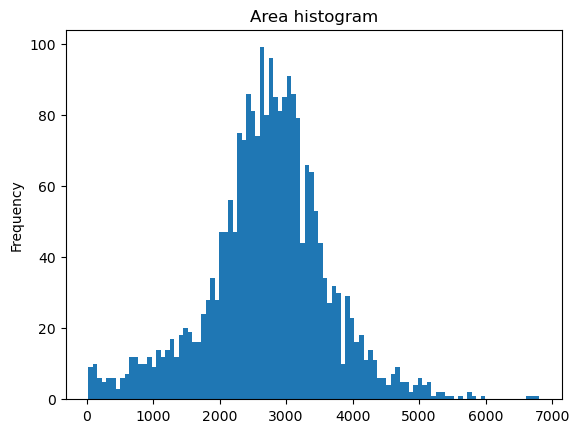

In [ ]:
params_df = estimate_parameters_from_labels(masks, is_timelapse=True)
if in_notebook:
    params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

## Optimize the tracking using optuna and ultrack

In [ ]:
config = MainConfig()
config.linking_config.max_distance = 50
config.tracking_config.disappear_weight = -0.2

pprint.pprint(config.dict())

{'data_config': {'address': None,
                 'database': 'sqlite',
                 'in_memory_db_id': 0,
                 'n_workers': 1,
                 'working_dir': '.'},
 'linking_config': {'distance_weight': 0.0,
                    'max_distance': 50,
                    'max_neighbors': 5,
                    'n_workers': 1,
                    'z_score_threshold': 5.0},
 'segmentation_config': {'anisotropy_penalization': 0.0,
                         'max_area': 1000000,
                         'max_noise': 0.0,
                         'min_area': 100,
                         'min_frontier': 0.0,
                         'n_workers': 1,
                         'random_seed': 'frame',
                         'threshold': 0.5,
                         'ws_hierarchy': 'area'},
 'tracking_config': {'appear_weight': -0.001,
                     'bias': -0.0,
                     'disappear_weight': -0.2,
                     'dismiss_weight_guess': None,
              

In [ ]:
track(
    foreground=detections,
    edges=edges,
    config=config,
    overwrite=True,
)

Adding nodes to database:   0%|          | 0/14 [00:00<?, ?it/s]

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 19.73it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter Method to value 3
Set parameter Seed to value 0
Set parameter PoolSolutions to value 10
Set parameter MIPGap to value 0.001
Set parameter MIPGapAbs to value 1e-10
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
NodeLimit  1073741824
SolutionLimit  1073741824
TimeLimit  36000
IntFeasTol  1e-06
MIPGap 

In [ ]:
tracks_df, graph = to_tracks_layer(config)
tracks_df = close_tracks_gaps(
    tracks_df=tracks_df,
    max_gap=2,
    max_radius=50,
    spatial_columns=["y", "x"],
)

In [ ]:
labels = tracks_to_zarr(config, tracks_df)
# save the tracks as parquet
tracks_df.to_parquet(
    f"{results_output_dir}/{str(input_dir).split('MaxIP_')[1]}_tracks.parquet"
)
print(tracks_df["track_id"].nunique())
print(f"Found {tracks_df['track_id'].nunique()} unique tracks in the dataset.")
tracks_df.head()

Exporting segmentation masks: 100%|██████████| 14/14 [00:00<00:00, 93.39it/s]

191
Found 191 unique tracks in the dataset.


,track_id,t,y,x,id,parent_track_id,parent_id
0,1,0.0,17.0,1273.0,1000005.0,-1,-1.0
1,1,1.0,41.0,1308.0,2000010.0,-1,1000005.0
2,1,2.0,38.0,1292.0,3000009.0,-1,2000010.0
3,1,3.0,36.0,1292.0,4000009.0,-1,3000009.0
4,1,4.0,34.0,1289.0,5000009.0,-1,4000009.0


In [ ]:
tracks_df.reset_index(drop=True, inplace=True)
tracks = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
cum_tracks_df = tracks_df.copy()
timepoints = tracks_df["t"].unique()

# zero out the track_df for plotting
cum_tracks_df = cum_tracks_df.loc[cum_tracks_df["t"] == -1]

In [ ]:
if in_notebook:
    for frame_index, _ in enumerate(nuclei):
        tmp_df = tracks_df.loc[tracks_df["t"] == frame_index]
        cum_tracks_df = pd.concat([cum_tracks_df, tmp_df])
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 3, 1)
        # rescale tbe intensity of the raw image
        raw_image = timelapse_raw[frame_index, :, :]
        raw_image = raw_image * 4096
        plt.imshow(nuclei[frame_index, :, :], cmap="gray")
        plt.title("Raw")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(detections[frame_index, :, :], cmap="gray")
        plt.title("Detections")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(detections[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"{temporary_output_dir}/tracks_{frame_index}.png")
        plt.close()

In [ ]:
# load each image
files = [f for f in temporary_output_dir.glob("*.png")]
files = sorted(files, key=lambda x: int(x.stem.split("_")[1]))
frames = [Image.open(f) for f in files]
fig_path = figures_output_dir / f"{str(input_dir).split('MaxIP_')[1]}_tracks.gif"
# plot the line of each track in matplotlib over a gif
# get the tracks
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=100, loop=0)

In [ ]:
# clean up tracking files
# remove temporary_output_dir
shutil.rmtree(temporary_output_dir)

track_db_path = pathlib.Path("data.db").resolve()
metadata_toml_path = pathlib.Path("metadata.toml").resolve()
if track_db_path.exists():
    track_db_path.unlink()
if metadata_toml_path.exists():
    metadata_toml_path.unlink()

In [ ]:
clear_gpu_memory()

In [ ]:
if in_notebook:
    viewer = napari.Viewer()
    viewer.window.resize(1200, 1200)

    viewer.add_image(nuclei, name="Raw", colormap="gray")

    viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
    viewer.add_labels(masks)

    viewer.layers["masks"].visible = False

    nbscreenshot(viewer)
    viewer.close()